### PyTorch Torchvision: Inference with ResNet50 and FPN

Step by step performing inference on test/ eval images.

In [7]:
# import necessary libraries
import os
import io
import random
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import onnxruntime as ort
from torchvision import transforms
from torchvision.transforms import v2
import torch
import numpy as np
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_V2_Weights, fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from matplotlib import patches
from torchvision.ops import nms
from contextlib import redirect_stdout
from pycocotools.coco import COCO
import openvino as ov
import tensorrt as trt
import onnx
import openvino.properties.hint as hints

In [8]:
# implement functions for basic usage
def select_and_view_random_image(target_dir, target_class):
    """
    Selects a random image from a specified directory and displays it.

    Parameters:
    target_dir (str): The base directory where the images are stored.
    target_class (str): The subdirectory within the base directory where the images are stored.

    Returns:
    img (numpy.ndarray): The selected image as a numpy array.
    """
    target_folder = target_dir + target_class
    image_files = [f for f in os.listdir(target_folder) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg')]
    random_image = random.sample(image_files, 1)

    img = mpimg.imread(target_folder + "/" + random_image[0])

    plt.imshow(img)
    plt.axis("off")

    print(f"Image shape: {img.shape}")
    print("Path: " + target_folder + "/" + random_image[0])

    return img

def simple_transform_image(img):
    img = img.copy()
    transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale = True),
        v2.ToDtype(torch.float32, scale = True),
    ])
    simple_transform_img = transform(img)
    return simple_transform_img

def preprocess_image(img):
    """
    Preprocesses an image by applying a series of transformations.

    Parameters:
    img (PIL.Image or ndarray): The input image.

    Returns:
    Tensor: The preprocessed image as a tensor.
    """
    img = img.copy()
    # define simple transformations to be applied to each image in the dataset
    transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale = True),
        v2.ToDtype(torch.float32, scale = True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # preprocess the image
    preprocess_img = transform(img)
    return preprocess_img

def postprocess_image(img):
    """
    Postprocesses an image by applying the inverse of the preprocessing transformations.

    Parameters:
    img (Tensor): The input image as a tensor.

    Returns:
    PIL.Image or ndarray: The postprocessed image.
    """
    # postprocess the image
    postprocess_img = untransform(img)
    return postprocess_img

def visualize_single_image(img):
    """
    This function takes an image tensor, permutes the dimensions to make it suitable for visualization (channels last),
    converts it to a numpy array, and then uses matplotlib's imshow function to display the image.
    """
    image_array = img.permute(1, 2, 0).numpy()

    plt.figure(figsize = (10, 10))
    plt.imshow(image_array)
    plt.axis('off')
    
    plt.show()

def visualize_both_images(img1, img2):
    """
    Visualizes two images side by side in a single row.

    Parameters:
    img1 (numpy.ndarray): The first image to be displayed.
    img2 (numpy.ndarray): The second image to be displayed.

    Returns:
    None. This function displays a plot but does not return anything.
    """
    # Transpose the images if necessary
    if img1.shape[0] == 3:
        img1 = np.transpose(img1, (1, 2, 0))
    if img2.shape[0] == 3:
        img2 = np.transpose(img2, (1, 2, 0))
    
    plt.figure(figsize = (10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis('off')
    plt.title('Pre')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis('off')
    plt.title('Post')

    plt.show()

def untransform(tensor):
    """
    Reverses the normalization transformation on a tensor.

    This function takes a tensor that has been normalized with a specific mean and standard deviation, and applies the inverse operations to return it to its original state. The resulting tensor is clamped to the range [0, 1] to ensure the values are valid for an image.

    Parameters:
    tensor (torch.Tensor): The normalized tensor to be untransformed.

    Returns:
    torch.Tensor: The untransformed tensor with values in the range [0, 1].
    """
    # denormalize the tensor by multiplying by the standard deviation and adding the mean
    # .clamp_(0, 1) function is used to ensure that the pixel values of the image remain within the valid range of [0,1] 
    # after the un-transformation
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    return (tensor * std + mean).clamp_(0, 1)

def visualize_result(img_tensor, result, category_mappings):
    """
    Visualizes the result of a model prediction.

    Parameters:
    img_tensor (torch.Tensor): The input image tensor.
    output (dict): The output from the model.

    Returns:
    None. This function displays a plot but does not return anything.
    """
    # convert the tensor to a numpy array
    img_array = img_tensor.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots()
    ax.imshow(img_array)
    
    boxes = result[0]['boxes']
    labels = result[0]['labels']
    scores = result[0]['scores']
    
    # define the overlap threshold for NMS
    iou_threshold = 0.5

    # perform non-maximum suppression
    keep = nms(boxes, scores, iou_threshold)

    kept_boxes = boxes[keep]
    kept_scores = scores[keep]
    kept_labels = labels[keep]

    for box, label, score in zip(kept_boxes, kept_labels, kept_scores):
      rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], 
        linewidth = 1, edgecolor = 'r', facecolor = 'none')
      ax.add_patch(rect)
      plt.text(box[0], box[1], f'{category_mappings[label.item()]}: {score:.2f}', color = 'r')

    plt.axis('off')
    plt.show()

Image shape: (600, 800, 3)
Path: ../../../dataset/aerial_maritime/test/images//DJI_0262_JPG.rf.db0ac6979f1ee032646972240830a550.jpg


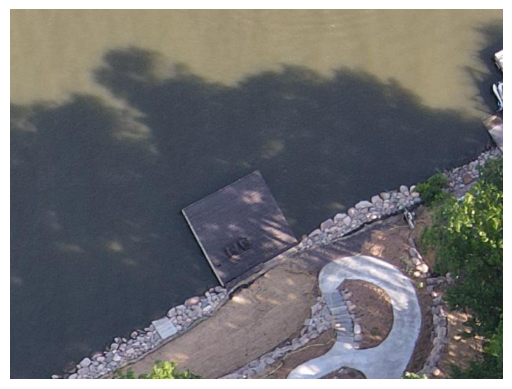

In [9]:
# select random image and display it
random_image = select_and_view_random_image(
    target_dir = "../../../dataset/aerial_maritime/test", 
    target_class = "/images/"
)

# temporarily redirect standard output to an in-memory text stream to suppress console output
with redirect_stdout(io.StringIO()):
    # initialize the COCO API for the training/ validation dataset
    coco_validation = COCO("../../../dataset/aerial_maritime/test/annotation/_annotations.coco.json")

# create dictionary mapping category IDs to category names
catId_to_name_validation = {cat['id']: cat['name'] for cat in coco_validation.loadCats(coco_validation.getCatIds())}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


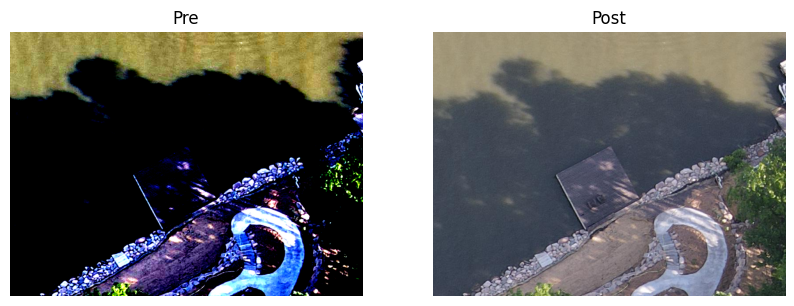

In [10]:
# normalize during preprocess and denormalize during postprocess
pre_img = preprocess_image(random_image)
post_img = postprocess_image(pre_img)

visualize_both_images(pre_img, post_img)

In [11]:
# simple transform image
simple_transform_img = simple_transform_image(random_image)

#### 1. Basic inference 

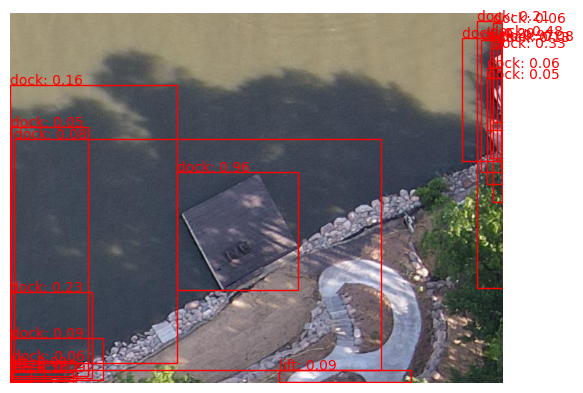

In [14]:
# load model with `state_dict`
# initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device("cpu")

class_number = 7
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT

model = fasterrcnn_resnet50_fpn_v2(weights = weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, class_number)

model.to(device)

model.load_state_dict(torch.load("model/resnet50v2-1.pth"))
model.eval()

with torch.inference_mode():
    simple_transform_img = simple_transform_img.to(device)
    output = model(simple_transform_img.unsqueeze(0))[0]
    output = [{k: v.to(cpu_device) for k, v in output.items()}]
    visualize_result(post_img, output, catId_to_name_validation)

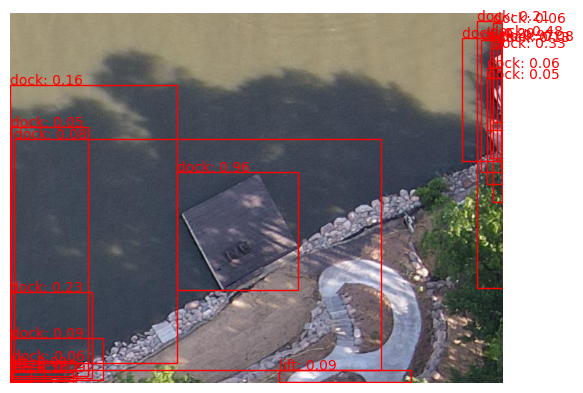

In [15]:
# load `entire` model
model = torch.load("model/resnet50v2-2.pth")
model.to(device)
model.eval()

with torch.inference_mode():
    simple_transform_img = simple_transform_img.to(device)
    output = model(simple_transform_img.unsqueeze(0))[0]
    output = [{k: v.to(cpu_device) for k, v in output.items()}]
    visualize_result(post_img, output, catId_to_name_validation)

code/__torch__/torchvision/models/detection/faster_rcnn.py:103: UserWarning: RCNN always returns a (Losses, Detections) tuple in scripting


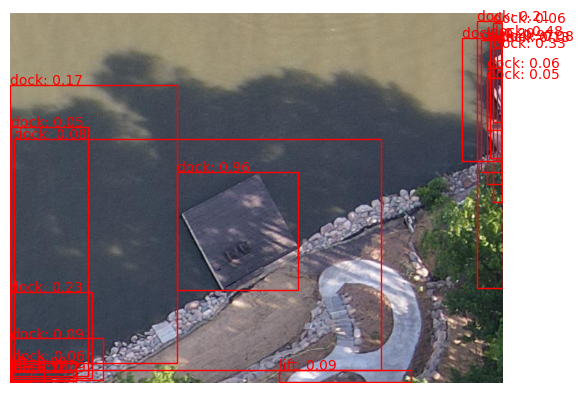

In [16]:
# load model in TorchScript format
model = torch.jit.load('model/resnet50v2-3.pth')
model.to(cpu_device)
model.eval()

with torch.inference_mode():
    simple_transform_img = simple_transform_img.to(cpu_device)
    output = model([simple_transform_img])[1][0]
    output = [{k: v.to(cpu_device) for k, v in output.items()}]
    visualize_result(post_img, output, catId_to_name_validation)

##### 2. Inference with ONNX

Kindly refer to resize_bounding_box.ipynb for info related to adjust the coordinates of the bounding box after prediction to correspond with the original image.

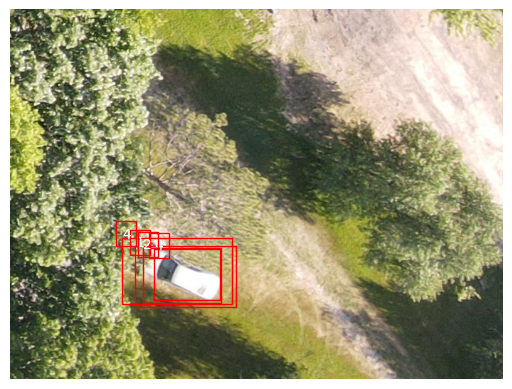

In [17]:
# select sample and display it
image_path = "../../../dataset/aerial_maritime/test/images/DJI_0262_JPG.rf.3878c367b5f00b7ce0f5c9bdcb4d8486.jpg"
image = Image.open(image_path)

# original image and its size
image_np = np.array(image)
original_size = image_np.shape
original_width, original_height = original_size[1], original_size[0]

# define the transformation pipeline for the image
resize_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    v2.Resize((640, 640), antialias = True),
    v2.ToDtype(torch.float32, scale = True),
])

# apply the transformation to the image
# image size [channels, height, width]
pre_img = resize_transform(image)
transformed_size_height = pre_img.numpy().shape[1]
transformed_size_width = pre_img.numpy().shape[2]

# step 1
# load the ONNX model from the specified file
# onnx_model = onnx.load("model/resnet50v2.onnx")
# check the loaded model for any inconsistencies or violations of the ONNX specification
# onnx.checker.check_model(onnx_model)
# session = ort.InferenceSession(onnx_model.SerializeToString())

# step 2
# load the ONNX model
session = ort.InferenceSession("model/resnet50v2.onnx")

# get the name of the input layer
input_name = session.get_inputs()[0].name

# run the model on the preprocessed image
outputs = session.run(None, {input_name: pre_img.unsqueeze(0).numpy()})

# create a figure and axes
fig, ax = plt.subplots(1)

# display the image
ax.imshow(image_np)
# ax.imshow(pre_img.permute(1, 2, 0).numpy())

# get the bounding boxes, labels and scores from the model's output
boxes = outputs[0]
labels = outputs[1]
scores = outputs[2]

# calculate scale factors
width_scale = original_width / transformed_size_width
height_scale = original_height / transformed_size_height

# scale the bounding boxes to match the original image size
scaled_boxes = []
for box in boxes:
    scaled_box = [
        box[0] * width_scale, 
        box[1] * height_scale, 
        box[2] * width_scale, 
        box[3] * height_scale
    ]
    scaled_boxes.append(scaled_box)

# for each bounding box
for box, label, score in zip(scaled_boxes, labels, scores):
    # create a rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
        linewidth = 1, edgecolor = 'r', facecolor = 'none')
    # add the patch to the axes
    ax.add_patch(rect)
    # add the label and score
    plt.text(box[0], box[1], f'{label}', color = 'white', 
        bbox = dict(facecolor = 'none', edgecolor = 'red'))

# off axis
plt.axis('off')
# show the figure
plt.show()

#### 3. Inference with OpenVINO
https://docs.openvino.ai/2023.3/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_ONNX.html
https://docs.openvino.ai/2023.3/openvino_docs_OV_UG_Integrate_OV_with_your_application.html

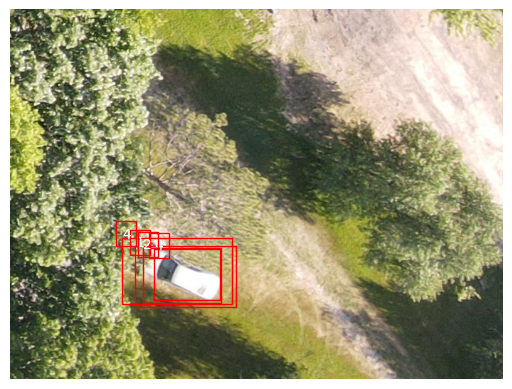

In [18]:
core = ov.Core()

# convert the ONNX model to an OpenVINO model
ov_model = ov.convert_model(
    'model/resnet50v2.onnx', 
    example_input = torch.rand(1, 3, 640, 640)
)

compiled_model = core.compile_model(
    model = ov_model, 
    device_name = "CPU"
)

prediction = compiled_model(pre_img.unsqueeze(0).numpy())

boxes = prediction[0]
labels = prediction[1]
scores = prediction[2]

# scale the bounding boxes to match the original image size
scaled_boxes = []
for box in boxes:
    scaled_box = [
        box[0] * width_scale, 
        box[1] * height_scale, 
        box[2] * width_scale, 
        box[3] * height_scale
    ]
    scaled_boxes.append(scaled_box)

# create a figure and axes
fig, ax = plt.subplots(1)

# display the image
# ax.imshow(pre_img.permute(1, 2, 0).numpy())
ax.imshow(image_np)

# for each bounding box
for box, label, score in zip(scaled_boxes, labels, scores):
    # create a rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
        linewidth = 1, edgecolor = 'r', facecolor = 'none')
    # add the patch to the axes
    ax.add_patch(rect)
    # add the label and score
    plt.text(box[0], box[1], f'{label}', color = 'white', 
        bbox = dict(facecolor = 'none', edgecolor = 'red'))

# off axis
plt.axis('off')
# show the figure
plt.show()

#### 4. Inference with TensorRT

In [19]:
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

def build_engine(onnx_file_path):
    with trt.Builder(TRT_LOGGER) as builder, builder.create_network() as network, trt.OnnxParser(network, TRT_LOGGER) as parser:
        # builder.max_workspace_size = 1 << 30  # adjust this value according to your memory availability
        
        # parse the ONNX model
        with open(onnx_file_path, 'rb') as model:
            if not parser.parse(model.read()):
                print('ERROR: Failed to parse the ONNX file.')
                for error in range(parser.num_errors):
                    print(parser.get_error(error))
                return None

        # configure precision and other settings
        config = builder.create_builder_config()
        config.set_flag(trt.BuilderFlag.FP16)  # example for FP16 precision mode
        
        # build and return the engine
        return builder.build_engine(network, config)

engine = build_engine('model/resnet50v2.onnx')

# serialize and save the engine
if engine:
    with open("model/resnet50v2.engine", "wb") as f:
        f.write(engine.serialize())

ERROR: Failed to parse the ONNX file.
In node -1 (importModel): INVALID_VALUE: Assertion failed: !mImporterCtx.network()->hasImplicitBatchDimension() && "This version of the ONNX parser only supports TensorRT INetworkDefinitions with an explicit batch dimension. Please ensure the network was created using the EXPLICIT_BATCH NetworkDefinitionCreationFlag."
